In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
import math

import viz_utils
import data_utils

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

mpl.rc('image', cmap='viridis')
plt.ion()
normal_font = {'family' : 'DejaVu Sans',
        'weight' : 'medium',
        'size'   : 6}
stats_font = {'family' : 'DejaVu Sans',
        'weight' : 'medium',
        'size'   : 6}
plt.rc('font', **normal_font)

print('Path to dataset:', data_utils.butter_data_path())

Path to dataset: s3://oedi-data-lake/butter


# 1. Load Data
Please see README.md for instructions on how to obtain this dataset

In [2]:
primary_filters = [
    ('dataset', 'in', ['201_pol','529_pollen','537_houses','connect_4','mnist','sleep','wine_quality_white']),
    ('shape', 'in', ['exponential','rectangle','trapezoid','rectangle_residual']),
    ('learning_rate', '<=', 0.00011),
    ('learning_rate', '>=', 0.00009),
    ('depth', '==', 3),
    ('label_noise', '==', 0.0)
]

others_sweep_filters = [
    ('dataset', 'in', ['connect_4']),
    ('shape', 'in', ['rectangle']),
    ('learning_rate', '<=', 0.00011),
    ('learning_rate', '>=', 0.00009),
    ('depth', '==', 3),
    ('label_noise', '==', 0.0)
]

columns = [
    "test_loss_median",
    "test_loss_stddev",
    "test_loss_avg",
    "experiment_id",
    "size",
    "num_free_parameters",
    'dataset',
    'epochs',
    'shape',
    'depth',
]

primary_sweep_summary = data_utils.read_pandas('primary_sweep_summary', columns=columns, filters=primary_filters)
epoch_300_sweep_summary = data_utils.read_pandas('300_epoch_sweep_summary', columns=columns, filters=others_sweep_filters)
epoch_30k_sweep_summary = data_utils.read_pandas('30k_epoch_sweep_summary', columns=columns, filters=others_sweep_filters)

# 2. Extract into long-format dataframe

In [3]:
def extract_data(original_df, downsample_epochs=False, num_epochs=100):

    original_df['epoch'] = original_df['test_loss_median'].apply(lambda x: list(range(1, 1 + len(x))))

    epoch_wise_values = ["test_loss_median", "test_loss_avg", "test_loss_stddev", "epoch"]

    df = original_df.explode(epoch_wise_values)

    for value in epoch_wise_values:
        df[value] = df[value].astype("float32")
    df["epoch"] = df["epoch"].astype("int")

    # downsample by epoch logarithmically
    if downsample_epochs:
        keep_epochs = np.unique(np.logspace(0,np.log10(df['epoch'].max()),num_epochs,base=10).astype(int))
        df = df[df["epoch"].isin(keep_epochs)]

    # num_free_parameters is not unique in sizes. Take one that is closest.
    df["__param__diff__"] = np.abs(df["num_free_parameters"] - df["size"])
    df = df.sort_values('__param__diff__').groupby(['dataset','shape','num_free_parameters','epoch']).first().reset_index()
    df = df.drop('__param__diff__', axis=1)
    return df

df = extract_data(primary_sweep_summary, downsample_epochs=False)
df_300 = extract_data(epoch_300_sweep_summary, downsample_epochs=False)
df_30k = extract_data(epoch_30k_sweep_summary, downsample_epochs=True, num_epochs=4000)

In [4]:
df.head()

,dataset,shape,num_free_parameters,epoch,test_loss_median,test_loss_stddev,test_loss_avg,experiment_id,size,epochs,depth
0,201_pol,exponential,561,1,2.374462,0.043156,2.382431,2069846,512,3000,3
1,201_pol,exponential,561,2,2.356995,0.043513,2.361323,2069846,512,3000,3
2,201_pol,exponential,561,3,2.337849,0.045224,2.339386,2069846,512,3000,3
3,201_pol,exponential,561,4,2.314695,0.048192,2.315838,2069846,512,3000,3
4,201_pol,exponential,561,5,2.288066,0.052211,2.290097,2069846,512,3000,3


# 3. Fit Functions to data

## A. Collect best epochs, losses, and descent slopes per dataset, shape, and size

In [5]:
datasets = ['201_pol', '529_pollen', '537_houses', 'connect_4', 'mnist', 'sleep', 'wine_quality_white'] 
shapes = ['exponential', 'rectangle', 'rectangle_residual', 'trapezoid']

In [6]:
best_epochs, best_losses, descent_slopes = dict(),dict(),dict()
for i,dataset in enumerate(datasets):
    best_epochs[dataset],best_losses[dataset],descent_slopes[dataset] = dict(),dict(),dict()
    row_df = df[(df['dataset']==dataset)]
    
    for j,shape in enumerate(shapes):
        best_epochs[dataset][shape],best_losses[dataset][shape],descent_slopes[dataset][shape] = dict(),dict(),dict()
        cell_df = row_df[(row_df['shape']==shape)]
        sizes_sorted = np.sort(cell_df['num_free_parameters'].unique())
        
        for size in sizes_sorted:
            size_df = cell_df[(cell_df['num_free_parameters']==size)]
            
            # 529_pollen task requires different parameterization of Savitzky-Golay filter
            if dataset=='529_pollen':
                
                # Filter the noisy log transformed data to measure minimizing epoch (best_epochs)
                x,y = data_utils.filter_log_loss(np.log10(size_df['epoch']), 
                                    np.log10(size_df['test_loss_median']), 
                                    np.linspace(np.log10(1),np.log10(3000),3000),window=901,polyorder=2)
                best_epochs[dataset][shape][size] = 10**x[np.argmin(y)]
                
                # Estimate descent slope in log-space
                percent_mins = (10**y)/(10**min(y))
                pre_min_above_threshold_indexes = np.where(percent_mins>1.1)[0][np.where(percent_mins>1.1)[0]<np.argmin(y)]
                if len(pre_min_above_threshold_indexes)==0:
                    descent_slopes[dataset][shape][size] = 0
                else:
                    backoff_idx = max(pre_min_above_threshold_indexes)
                    descent_slopes[dataset][shape][size] = ((10**y[backoff_idx]-10**min(y))/
                                                            (10**x[backoff_idx]-10**x[np.argmin(y)]))
                
                # Filter the noisy log transformed data to measure minimum loss (best_losses)
                x,y = data_utils.filter_log_loss(np.log10(size_df['epoch']), 
                                        np.log10(size_df['test_loss_median']), 
                                        np.linspace(np.log10(1),np.log10(3000),3000))
                best_losses[dataset][shape][size] = 10**min(y)
            
            else:
                # Filter the noisy log transformed data to measure minimizing epoch (best_epochs)
                # and minimum losses (best_losses)
                x,y = data_utils.filter_log_loss(np.log10(size_df['epoch']), 
                                        np.log10(size_df['test_loss_median']), 
                                        np.linspace(np.log10(1),np.log10(3000),3000))
                best_epochs[dataset][shape][size] = 10**x[np.argmin(y)]
                best_losses[dataset][shape][size] = 10**min(y)
            
                # Estimate descent slope in log-space
                percent_mins = (10**y)/(10**min(y))
                pre_min_above_threshold_indexes = np.where(percent_mins>1.1)[0][np.where(percent_mins>1.1)[0]<np.argmin(y)]
                if len(pre_min_above_threshold_indexes)==0:
                    descent_slopes[dataset][shape][size] = 0
                else:
                    backoff_idx = max(pre_min_above_threshold_indexes)
                    descent_slopes[dataset][shape][size] = ((10**y[backoff_idx]-10**min(y))/
                                                            (10**x[backoff_idx]-10**x[np.argmin(y)]))

In [7]:
best_epochs['mnist']['rectangle']

{807: 781.2141485949535,
 2407: 2999.999999999998,
 4015: 1962.331514669683,
 8070: 370.9283236572732,
 16330: 230.0131061432789,
 32575: 134.49550723144273,
 65335: 82.95670797963527,
 131050: 58.94471428500837,
 261510: 38.45356099924526,
 523882: 27.39613820350058,
 1049407: 22.909085153396774,
 2097610: 16.496744136196366,
 4193002: 11.352159212739933,
 8391382: 10.877463711780514,
 16774831: 10.20237770596298}

## B. Fit analytical functions to extracted statistics

In [8]:
parameters = {d:{s:dict() for s in shapes} for d in datasets}

### i. Equation 1

$ {\theta_{min}}^{-1/3} = m\log(\sigma) + b $

In [9]:
for i,dataset in enumerate(datasets):
    for j,shape in enumerate(shapes):
        sizes_sorted = np.sort(list(best_epochs[dataset][shape].keys()))
        epochs = np.asarray([best_epochs[dataset][shape][s] for s in sizes_sorted])
        
        # Only fit to monotonically decreasing epochs less that 2900
        fit_idxs = [np.argmin(epochs)]
        for i in range(np.argmin(epochs)-1,-1,-1):
            if epochs[i] < 2900 and epochs[i] > epochs[i+1]:
                fit_idxs.append(i)

        # Fit Equation 1 from paper
        p,_ = curve_fit(data_utils.equation_1, 
                        np.log10(sizes_sorted[fit_idxs]), np.power(epochs[fit_idxs],-1/3))
        
        parameters[dataset][shape]['minimizing_epoch'] = p

In [10]:
parameters['mnist']['rectangle']

{'minimizing_epoch': array([ 0.10727955, -0.28927895])}

### ii. Equation 2

$ \log(\phi_{min}) = c(\log(\sigma) - \varsigma_0)^{-p} + \varphi $

In [11]:
for i,dataset in enumerate(datasets):
    last_parameters = []
    for j,shape in enumerate(shapes):
        sizes_sorted = np.sort(list(best_losses[dataset][shape].keys()))
        losses = [best_losses[dataset][shape][s] for s in sizes_sorted]

        # Fit Equation 2 from paper, using inital parameters from previous fit shapes
        p,_ = curve_fit(data_utils.equation_2,np.log10(sizes_sorted),np.log10(losses),
                        p0=([5,0.5,0,0] if len(last_parameters)==0 else [last_parameters[0],last_parameters[1],0,last_parameters[3]]),
                        bounds=([0,0,0,-np.inf],[np.inf,np.inf,np.inf,np.inf]))
        
        parameters[dataset][shape]['minimum_loss'] = p
        last_parameters=p

In [12]:
parameters['mnist']['rectangle']

{'minimizing_epoch': array([ 0.10727955, -0.28927895]),
 'minimum_loss': array([ 5.73834678e+01,  3.29807335e+00,  5.08830406e-19, -1.29683270e+00])}

### iii. Equation 3

$ \alpha = \frac{\Delta \log(\phi)}{\Delta \log(\theta)} = -l (\log(\sigma)-\varsigma_1)^2 + \alpha_0 $

In [13]:
for i,dataset in enumerate(datasets):
    last_parameters = []
    for j,shape in enumerate(shapes):
        sizes_sorted = np.sort(list(descent_slopes[dataset][shape].keys()))
        epochs = [np.log10(best_epochs[dataset][shape][s]) for s in sizes_sorted]
        slopes = np.asarray([descent_slopes[dataset][shape][s] for s in sizes_sorted])

        # Fit to the same sizes as Equation 1
        fit_idxs = [np.argmin(epochs)]
        for i in range(np.argmin(epochs)-1,-1,-1):
            if epochs[i] < 2900 and epochs[i] > epochs[i+1]:
                fit_idxs.append(i)
        
        # Fit Equation 3 from paper, using inital parameters from previous fit shapes
        p,_ = curve_fit(data_utils.equation_3,
                        np.log10(sizes_sorted[fit_idxs][slopes[fit_idxs]!=0]),
                        slopes[fit_idxs][slopes[fit_idxs]!=0],
                        p0=([0.5,0,0] if len(last_parameters)==0 else [0,last_parameters[1],last_parameters[2]]),
                        bounds=([0,-np.inf,-np.inf],[np.inf,np.inf,np.inf]))
        
        parameters[dataset][shape]['descent_slope'] = p
        last_parameters=p

In [14]:
parameters['mnist']['rectangle']

{'minimizing_epoch': array([ 0.10727955, -0.28927895]),
 'minimum_loss': array([ 5.73834678e+01,  3.29807335e+00,  5.08830406e-19, -1.29683270e+00]),
 'descent_slope': array([7.22824624e-05, 2.35517606e+00, 1.02673908e-04])}

# 4. Visualize data

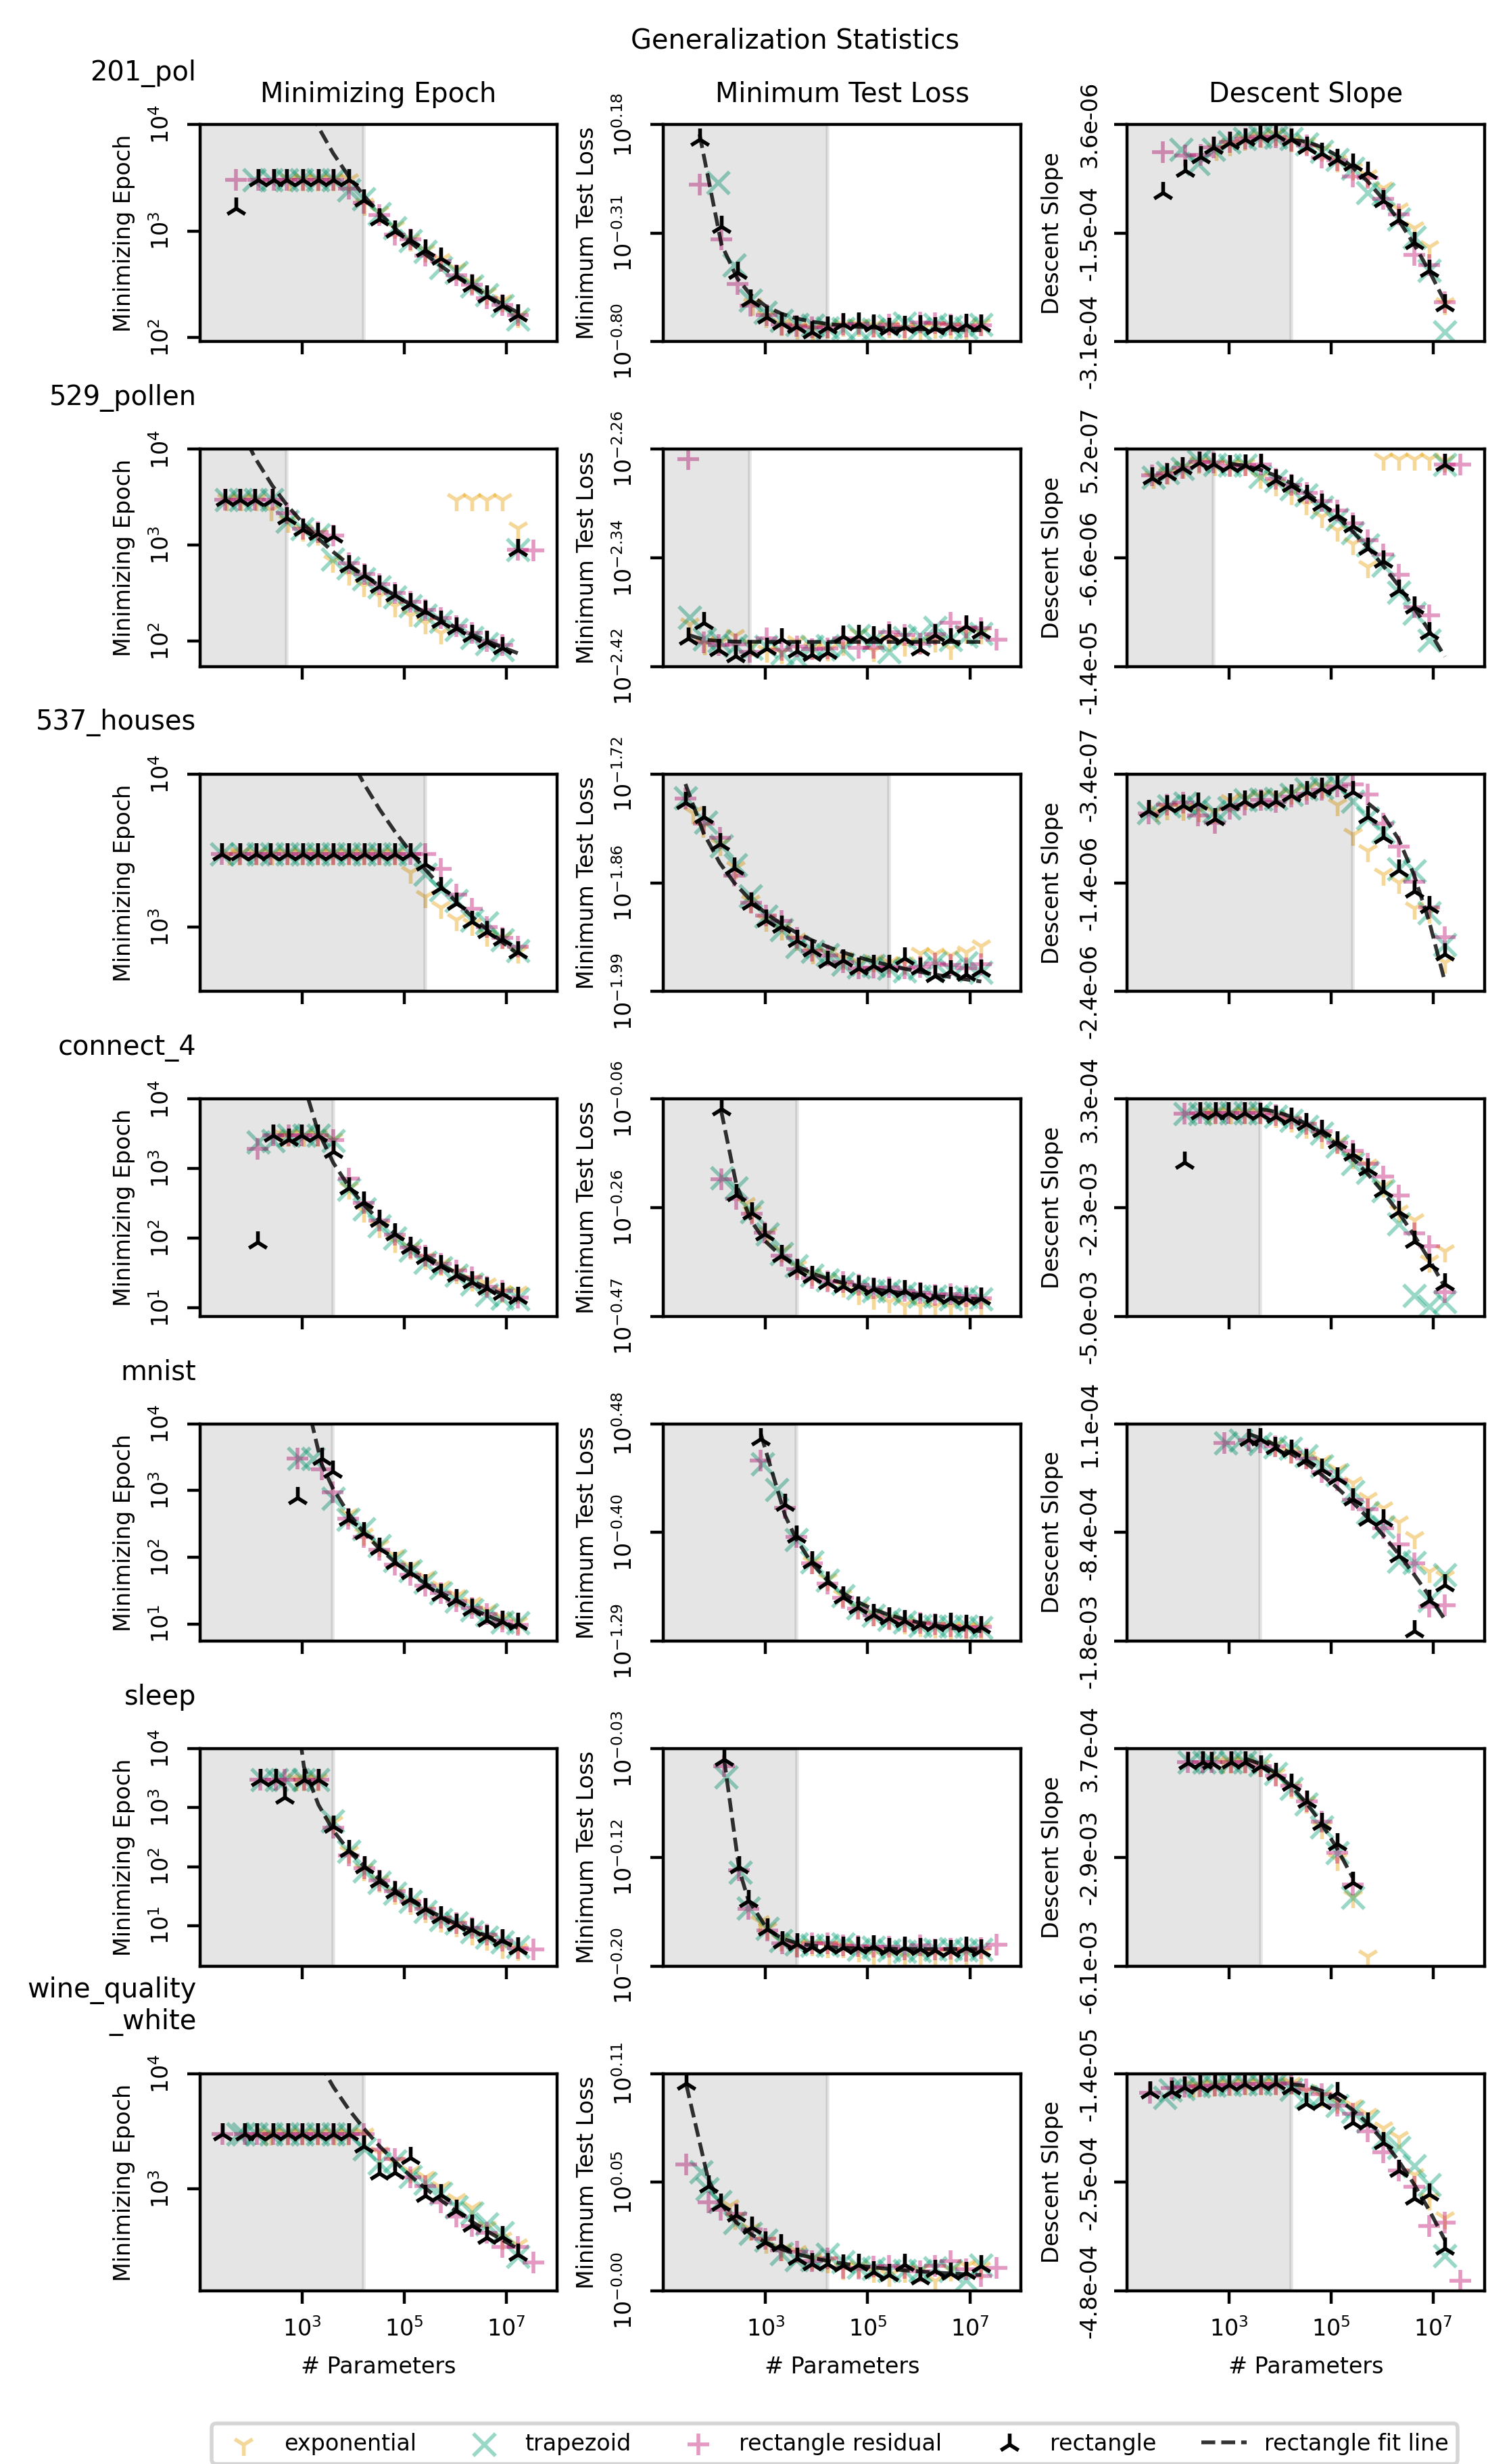

In [15]:
parameter_labels = {0:'Minimizing Epoch',1:'Minimum Test Loss', 2:'Descent Slope'}
markers = {'exponential':'1','rectangle':'2','trapezoid':'x','rectangle_residual':'+'}
colors = {'exponential':'#E69F00','rectangle':'black','trapezoid':'#009E73','rectangle_residual':'#BD026A'}
epoch_y_ticks = {'201_pol':[2,3,5],'529_pollen':[2,3],'537_houses':[3,4],'connect_4':[1,2,5],
                 'mnist':[1,2,3],'sleep':[1,2,3],'wine_quality_white':[3,4]}

fig,axs = plt.subplots(7,3,figsize=(5.5,9),dpi=400)
for i,dataset in enumerate(datasets):
    for k in range(3):
        ax = axs[i,k]
        for j,shape in enumerate(['exponential','trapezoid','rectangle_residual','rectangle']):
            sizes_sorted = np.sort(list(best_epochs[dataset][shape].keys()))
            x = np.asarray([np.log10(s) for s in sizes_sorted])
            
            # Plot Minimizing Epoch (First Column)
            if k==0:
                epochs = np.asarray([best_epochs[dataset][shape][s] for s in sizes_sorted])
                
                # Show the analytical fit line for rectangular networks only
                if shape=='rectangle':
                    
                    # Choose the fit indexes as before
                    fit_idxs = [np.argmin(epochs)]
                    for e in range(np.argmin(epochs)-1,-1,-1):
                        if epochs[e] < 2900 and epochs[e] > epochs[e+1]:
                            fit_idxs.append(e)
                    
                    # Select parameters, plot data, line defined by equation 1, shaded area
                    # covering points not used to estimate line
                    p = parameters[dataset]['rectangle']['minimizing_epoch']
                    ax.scatter(x,
                               np.log10(epochs),
                               color=colors[shape],label=shape.replace('_',' '),
                               alpha=1,s=35,marker=markers[shape],linewidths=1)
                    ax.plot(x,
                            np.log10(np.power([data_utils.equation_1(xi,p[0],p[1]) for xi in x],-3)),
                            color='black',alpha=0.8,linestyle='dashed',lw=1,label='rectangle fit line')
                    ax.axvspan(1, min(x[fit_idxs]), 
                               color='black', alpha=0.1)
                
                # Just plot the data points alone for the other network shapes
                else:
                    ax.scatter(x,
                               np.log10(epochs),
                               color=colors[shape],label=shape.replace('_',' '),
                                   alpha=0.4,s=35,marker=markers[shape],linewidths=1)
                    
            # Plot Minimum Test Loss (Second Column)
            elif k==1:
                losses = np.asarray([best_losses[dataset][shape][s] for s in sizes_sorted])
                
                # Show the analytical fit line for rectangular networks only
                if shape=='rectangle':
                    
                    # Select parameters, plot data, line defined by equation 2, shaded area
                    # covering points not used to estimate equation 1 line
                    p = parameters[dataset]['rectangle']['minimum_loss']
                    ax.scatter(x,
                               np.log10(losses),
                               color=colors[shape],label=shape.replace('_',' '),
                               alpha=1,s=35,marker=markers[shape],linewidths=1)
                    ax.plot(x,
                            [data_utils.equation_2(xi,p[0],p[1],p[2],p[3]) for xi in x],
                            color='black',alpha=0.8,linestyle='dashed',lw=1)
                    ax.axvspan(1, min(x[fit_idxs]), color='black', alpha=0.1)
                
                # Just plot the data points alone for the other network shapes
                else:
                    ax.scatter(x,
                               np.log10(losses),
                               color=colors[shape],label=shape.replace('_',' '),
                               alpha=0.4,s=35,marker=markers[shape],linewidths=1)

            # Plot Descent Slope (Third Column)
            else:
                slopes = np.asarray([descent_slopes[dataset][shape][s] for s in sizes_sorted])
                
                # Show the analytical fit line for rectangular networks only
                if shape=='rectangle':
                    
                    # Select parameters, plot data, line defined by equation 3, shaded area
                    # covering points not used to estimate equation 1 line
                    p = parameters[dataset]['rectangle']['descent_slope']
                    ax.plot(x[slopes!=0][x[slopes!=0]>p[1]],
                    [data_utils.equation_3(xi,p[0],p[1],p[2]) for xi in x[slopes!=0][x[slopes!=0]>p[1]]],
                            color='black',alpha=0.8,linestyle='dashed',lw=1)
                    ax.scatter(x[slopes!=0],
                               slopes[slopes!=0],
                               color=colors[shape],label=shape.replace('_',' '),
                               alpha=1,s=35,marker=markers[shape],linewidths=1)
                    ax.axvspan(1, min(x[fit_idxs]), color='black', alpha=0.1)
                
                # Just plot the data points alone for the other network shapes
                else:
                    ax.scatter(x[slopes!=0],
                               slopes[slopes!=0],
                               color=colors[shape],label=shape.replace('_',' '),
                               alpha=0.4,s=35,marker=markers[shape],linewidths=1)
                    

        
        # Set parameters for each column's plot
        if k==0:
            ax.set_ylim((ax.get_ybound()[0],4))
            y_ticks = [i for i in range(math.ceil(ax.get_ybound()[0]),5)]
            y_labels = ['$10^{'+str(i)+'}$' for i in y_ticks]
            ax.set_yticks(y_ticks,labels=y_labels,**{'rotation':90,
                                                  'verticalalignment':'center',
                                                  'fontsize':6})
            if dataset == 'wine_quality_white':
                ax.set_title('wine_quality\n_white',x=-0.01,y=1.1,loc='right')
            else:
                ax.set_title(dataset,x=-0.01,y=1.1,loc='right')        
        elif k==1:
            y_bounds = ax.get_ybound()
            y_ticks = np.linspace(y_bounds[0],y_bounds[1],3)
            y_labels = ['$10^{'+'{0:.2f}'.format(i)+'}$' for i in y_ticks]
            ax.set_yticks(y_ticks,labels=y_labels,**{'rotation':90,
                                                          'verticalalignment':'center',
                                                          'fontsize':6})
        else:
            y_bounds = ax.get_ybound()
            y_ticks = np.linspace(y_bounds[0],y_bounds[1],3)
            y_labels = ['{0:.1e}'.format(i) for i in y_ticks]
            ax.set_yticks(y_ticks,labels=y_labels,**{'rotation':90,
                                                          'verticalalignment':'center',
                                                          'fontsize':6})
            
        # Set parameters for plots in general        
        ax.set_xlim((1,8))
        x_bounds = ax.get_xbound()
        x_ticks = [3,5,7]
        x_labels = ['$10^{'+str(i)+'}$' for i in x_ticks]
        ax.set_xticks(x_ticks,labels=x_labels,**{'fontsize':6})
        ax.set_ylabel(parameter_labels[k])

        if i==0:
            ax.set_title(parameter_labels[k])
        if i==6:
            ax.set_xlabel('# Parameters')
        else:
            ax.set_xticklabels([])

# Set up legend and show figure          
h, l = axs[0,0].get_legend_handles_labels()
fig.legend(h,l,loc=(0.14,0),ncol=5)
fig.tight_layout(h_pad=0)
fig.suptitle('Generalization Statistics',x=0.52,y=0.99)
fig.subplots_adjust(top=0.95,bottom=0.06,left=0.12)
fig.show()

# 5. Predict points for other sweeps

## A. Preprocess data

In [16]:
def preprocess_variables(df, group_by=[]):

    #test_loss_median_processed
    df['test_loss_median_processed'] = df['test_loss_median']

    grouper = df.groupby(group_by)['test_loss_median_processed']
    mins = grouper.transform('min')
    df['test_loss_median_processed'] = -np.log10(np.minimum(2,df['test_loss_median_processed'] / mins).astype(float)-(1-1e-1))

    grouper = df.groupby(group_by)['test_loss_median_processed']
    mins = grouper.transform('min')
    maxs = grouper.transform('max')
    df['test_loss_median_processed'] = (df['test_loss_median_processed'] - mins)/(maxs-mins)

    #test_loss_median_processed_nocap
    df['test_loss_median_processed_nocap'] = df['test_loss_median']

    grouper = df.groupby(group_by)['test_loss_median_processed_nocap']
    mins = grouper.transform('min')
    df['test_loss_median_processed_nocap'] = -np.log10(df['test_loss_median_processed_nocap'] / mins).astype(float)-(1-1e-1)

    grouper = df.groupby(group_by)['test_loss_median_processed_nocap']
    mins = grouper.transform('min')
    maxs = grouper.transform('max')
    df['test_loss_median_processed_nocap'] = (df['test_loss_median_processed_nocap'] - mins)/(maxs-mins)
    
    #test_loss_cov
    df['test_loss_cov'] = df['test_loss_stddev']/df['test_loss_avg']

    #test_loss_cov_processed
    df['test_loss_cov_processed'] = np.log1p(10*df['test_loss_cov'])
    grouper = df.groupby(group_by)['test_loss_cov_processed']
    mins = grouper.transform('min')
    maxs = grouper.transform('max')
    df['test_loss_cov_processed'] = (df['test_loss_cov_processed'] - mins)/(maxs-mins)

    return df

df = preprocess_variables(df, group_by=['dataset','shape'])
df_300 = preprocess_variables(df_300, group_by=['dataset','shape'])
df_30k = preprocess_variables(df_30k, group_by=['dataset','shape'])

## B. Extract minimizing epochs for other sweeps

In [17]:
df_300_best_epochs, df_30k_best_epochs = dict(),dict()

for size in np.sort(df_300['num_free_parameters'].unique()):
    size_df = df_300[(df_300['num_free_parameters']==size)]
    x,y = data_utils.filter_log_loss(np.log10(size_df['epoch'].astype(float)), 
                            np.log10(size_df['test_loss_median'].astype(float)), 
                            np.linspace(np.log10(1),np.log10(300),300))
    df_300_best_epochs[size] = 10**x[np.argmin(y)]
    
for size in np.sort(df_30k['num_free_parameters'].unique()):
    size_df = df_30k[(df_30k['num_free_parameters']==size)]
    x,y = data_utils.filter_log_loss(np.log10(size_df['epoch'].astype(float)), 
                            np.log10(size_df['test_loss_median'].astype(float)), 
                            np.linspace(np.log10(1),np.log10(30000),4000))
    
    df_30k_best_epochs[size] = 10**x[np.argmin(y)]

In [18]:
df_30k_best_epochs

{135: 384.64891382820963,
 269: 30000.000000000196,
 543: 11119.636137858068,
 969: 30000.000000000196,
 2033: 12616.794408682388,
 4085: 2214.348073829862,
 8145: 533.6403450234466,
 16305: 299.5485148060168,
 32769: 162.6040664542242,
 65673: 108.76270759131987,
 130769: 75.81263334199005,
 262485: 53.25517720840317}

## C. Visualize predictions

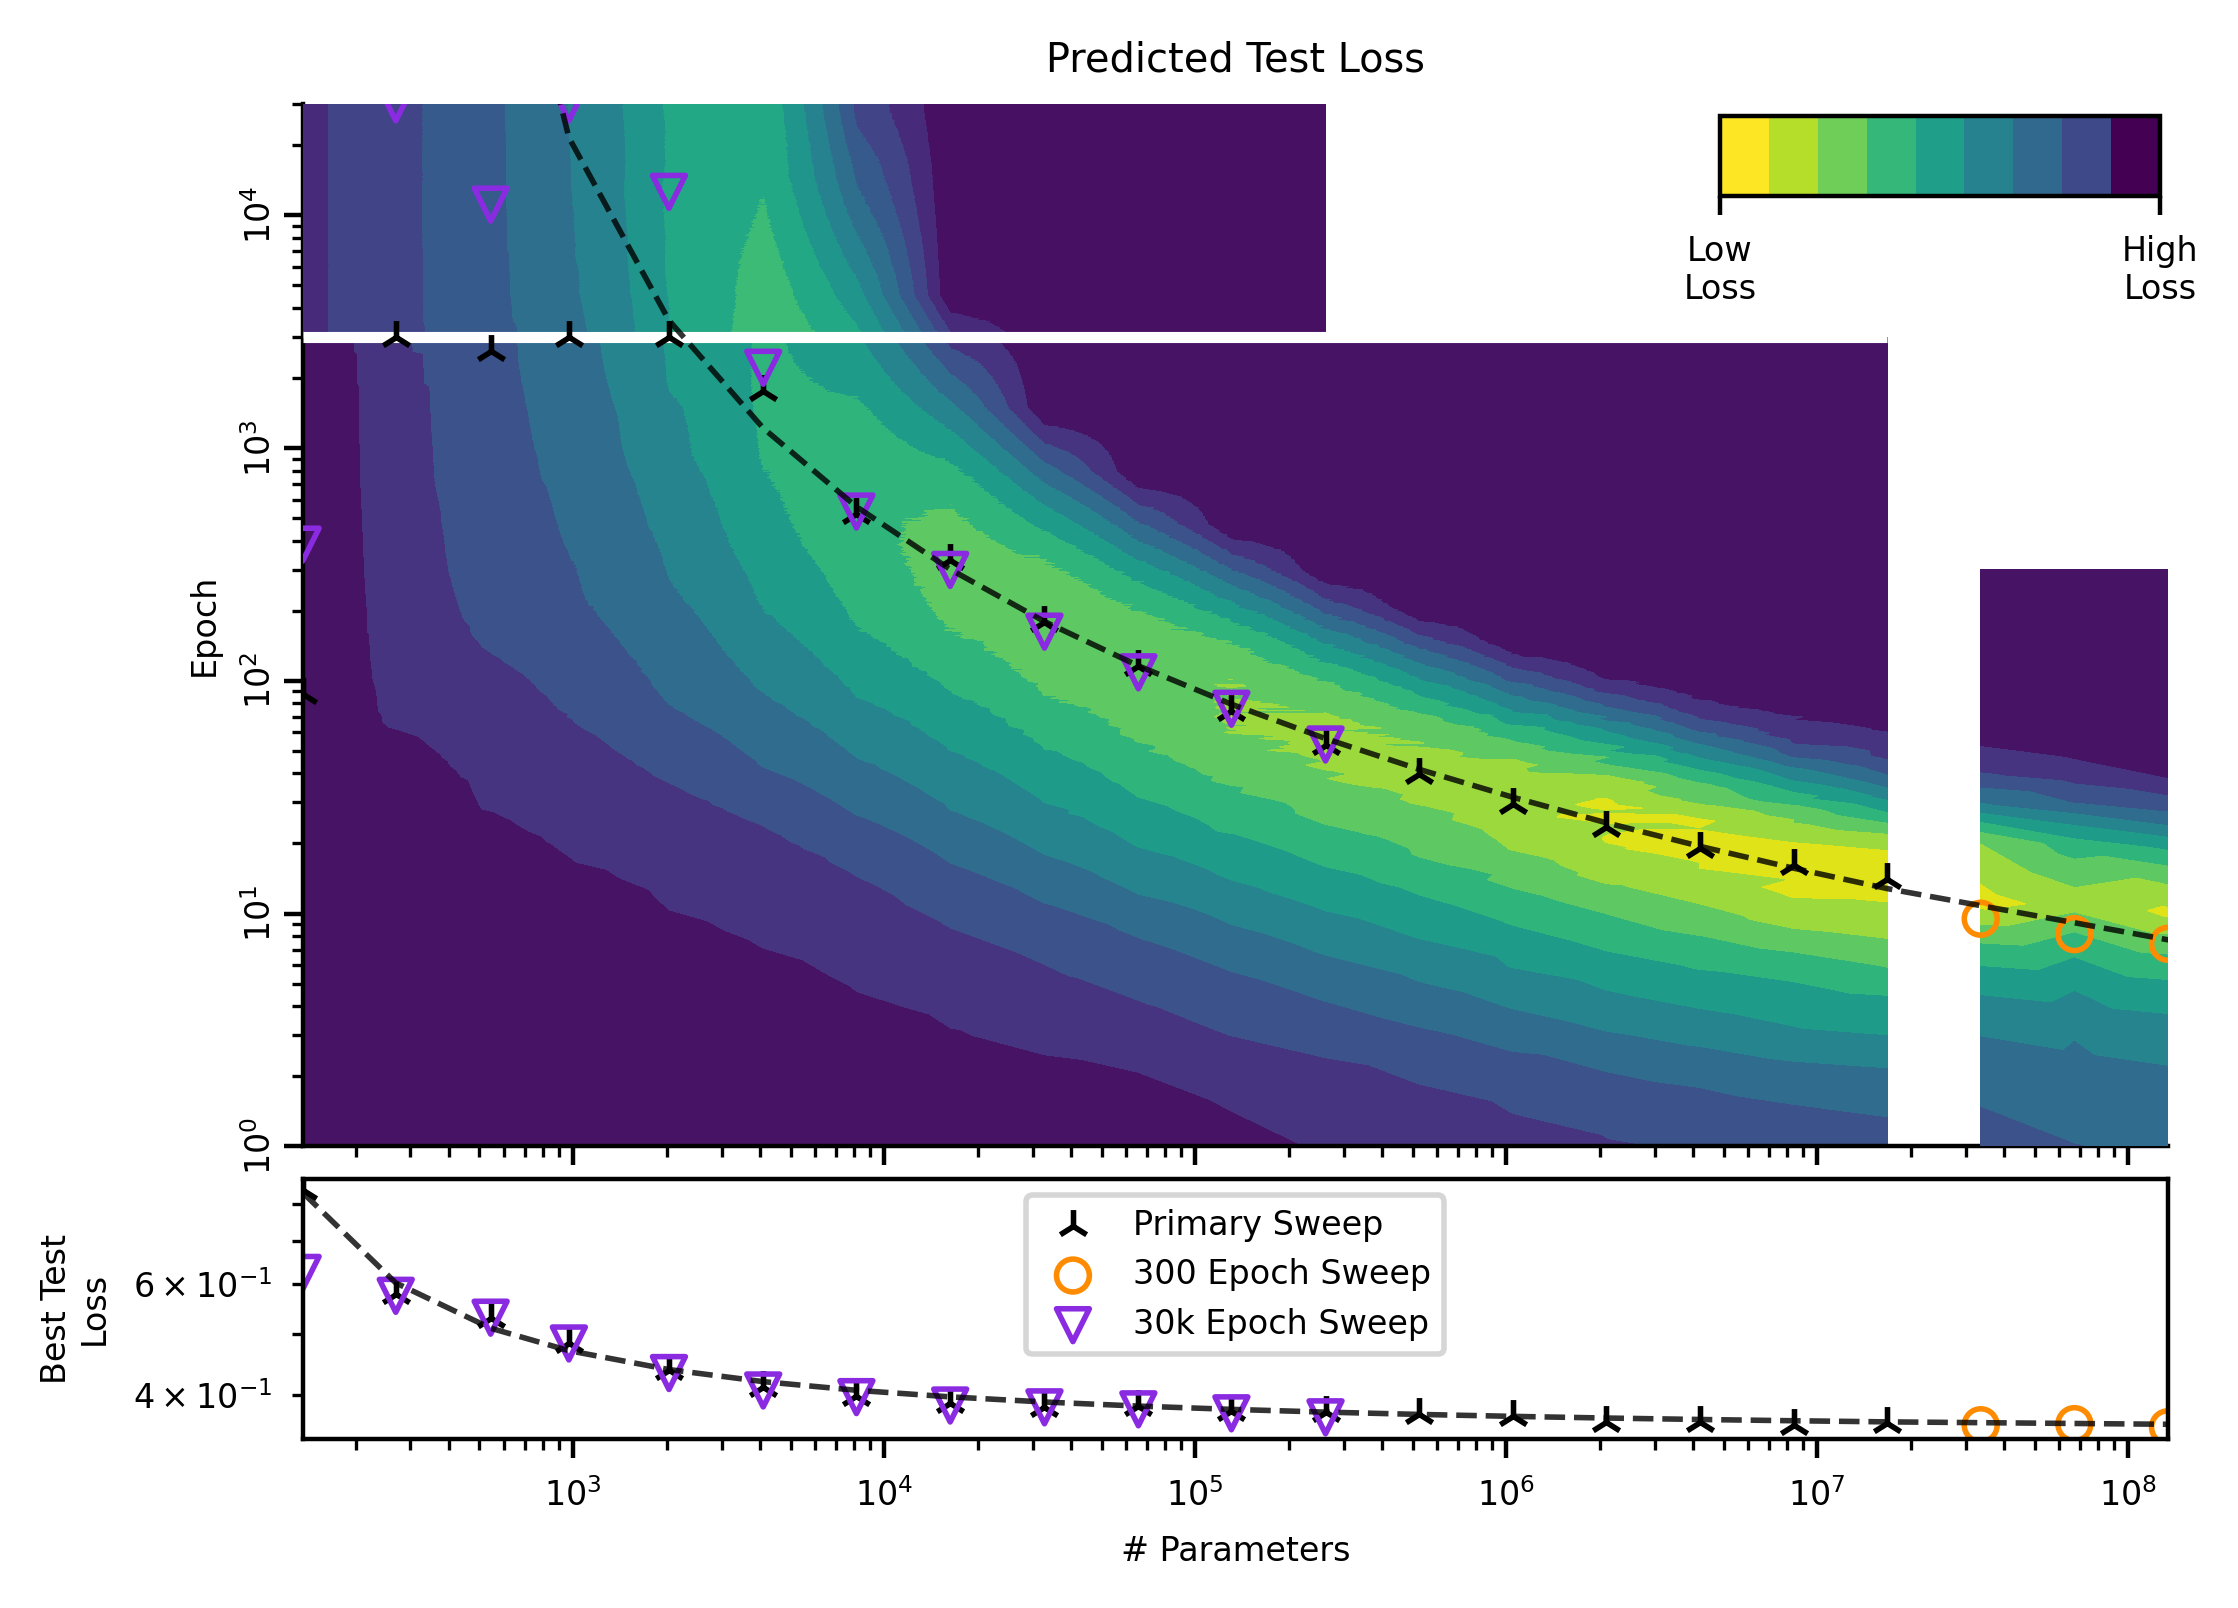

In [19]:
colors = {'df':'black','df_300':'darkorange','df_30k':'blueviolet'}
fig2,axs = plt.subplots(2,1,figsize=(5.5,4),sharex=True,
                        gridspec_kw={'height_ratios':[0.8,0.2]},dpi=400)

viz_data = df[(df['dataset']=='connect_4') &
          (df['shape']=='rectangle')]

# Visualize Primary Sweep
plt.subplot(2,1,1)
viz_utils.do_viz(viz_data,{
            'epoch': '**Y**',
            'size': '**X**',
            'dataset':'connect_4',
            'shape':'rectangle',
            },'test_loss_median_processed',log_x=True,log_y=True,log_z=False,plot_data_points=False,
       contour_levels=10,title='',y_label=False)

# Set parameters for plot
plt.ylim((1,30000))
plt.xlim((viz_data['num_free_parameters'].min(),df_300['num_free_parameters'].max()))
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].yaxis.set_ticks_position('left')
axs[0].xaxis.set_ticks_position('bottom')
axs[0].set_xlabel('')
axs[0].tick_params('x', labelbottom=False)
axs[0].set_title('Predicted Test Loss')
axs[0].set_ylabel('Epoch')

# Format colorbar
cax = plt.axes([0.78, 0.88, 0.2, 0.05])
bounds = np.linspace(0, 1, 10)
cmap = mpl.colors.ListedColormap(mpl.cm.get_cmap('viridis_r', 10)(bounds))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap,norm=norm),cax=cax,orientation='horizontal')
cbar.ax.set_xticks([0,1],labels=['Low\nLoss', 'High\nLoss'])

# Load parameters and data for plotting predictions based on extracted data
sizes_sorted = np.sort(list(best_epochs['connect_4']['rectangle'].keys()))
p = parameters['connect_4']['rectangle']['minimizing_epoch']
l = parameters['connect_4']['rectangle']['minimum_loss']
x = (sizes_sorted.tolist() + 
     [2**(np.log2(viz_data['num_free_parameters'].max())+5)])

# Add 300 Epoch Sweep
ax = fig2.add_subplot(2,1,1)
ax.set_ylim((1,30000))
ax.set_xlim((viz_data['num_free_parameters'].min(),df_300['num_free_parameters'].max()))
ax.set_yscale('log')
ax.set_xscale('log')
ax.axis('off')
viz_utils.do_viz(df_300,{
            'epoch': '**Y**',
            'size': '**X**',
            'dataset':'connect_4',
            'shape':'rectangle',
            },'test_loss_median_processed',log_x=True,log_y=True,log_z=False,plot_data_points=False,
       contour_levels=10,title='',y_label=False)

# Add 30k Epoch Sweep
ax = fig2.add_subplot(2,1,1)
ax.set_ylim((1,30000))
ax.set_xlim((viz_data['num_free_parameters'].min(),df_300['num_free_parameters'].max()))
ax.set_yscale('log')
ax.set_xscale('log')
ax.axis('off')
viz_utils.do_viz(df_30k[df_30k['epoch']>3000],{
            'epoch': '**Y**',
            'size': '**X**',
            'dataset':'connect_4',
            'shape':'rectangle',
            },'test_loss_median_processed',log_x=True,log_y=True,log_z=False,plot_data_points=False,
       contour_levels=10,title='',y_label=False,vmin=0,vmax=1)

ax.hlines(3001,min(sizes_sorted),sizes_sorted[-1],color='white',lw=2)

# Plot line
ax = fig2.add_subplot(2,1,1)
ax.plot(x[2:],
          [(np.power(data_utils.equation_1(xi,p[0],p[1]),-3)) for xi in np.log10(x[2:])],
          color='black',linestyle='dashed',alpha=0.8,lw=1)

ax.set_ylim((1,30000))
ax.set_xlim((viz_data['num_free_parameters'].min(),df_300['num_free_parameters'].max()))
ax.set_yscale('log')
ax.set_xscale('log')
ax.axis('off')

# Plot extracted points
b_epochs = np.asarray([best_epochs['connect_4']['rectangle'][s] for s in sizes_sorted])
ax.scatter(sizes_sorted,b_epochs,marker='2',s=35,linewidths=1,color=colors['df'])

b_epochs = np.asarray([df_300_best_epochs[s] for s in df_300_best_epochs.keys()])
ax.scatter(df_300_best_epochs.keys(),b_epochs,marker='o',s=35,linewidths=1,
           edgecolors=colors['df_300'],facecolors='none')

b_epochs = np.asarray([df_30k_best_epochs[s] for s in df_30k_best_epochs.keys()])
ax.scatter(df_30k_best_epochs.keys(),b_epochs,marker='v',s=35,linewidths=1,
           edgecolors=colors['df_30k'],facecolors='none')

# Plot data in the bottom half of the figure
ax = axs[1]
ax.plot(x,
       [10**data_utils.equation_2(np.log10(xi),l[0],l[1],l[2],l[3]) for xi in x],
       color='black',alpha=0.8,linestyle='dashed',lw=1)

df_data = viz_data.groupby('num_free_parameters')['test_loss_median'].min()
ax.scatter(df_data.index,df_data,s=35,marker='2',linewidths=1,label='Primary Sweep',color=colors['df'])

df_300_data = df_300.groupby('num_free_parameters')['test_loss_median'].min()
ax.scatter(df_300_data.index,df_300_data,s=35,marker='o',linewidths=1,label='300 Epoch Sweep',
           edgecolors=colors['df_300'],facecolors='none')

df_30k_data = df_30k.groupby('num_free_parameters')['test_loss_median'].min()
ax.scatter(df_30k_data.index,df_30k_data,s=35,marker='v',linewidths=1,label='30k Epoch Sweep',
           edgecolor=colors['df_30k'],facecolors='none')

# Set parameters for plot
y_bounds = ax.get_ybound()
y_ticks = np.linspace(y_bounds[0],y_bounds[1],7)[[1,3,5]]
y_labels = ['$10^{'+str(np.log10(i))+'}$' for i in y_ticks]
ax.set_yticks(y_ticks,labels=y_labels)
ax.set_ylabel('Best Test\nLoss')
ax.legend(loc=9)
ax.set_yscale('log')
ax.set_xlabel('# Parameters')

# Show plot
fig2.tight_layout(h_pad=0.1)
fig2.show()